In [1]:
# check against table

In [2]:
import os
import cantera as ct
import numpy as np
import pandas as pd
import concurrent.futures


import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Take Reactor Conditions from Table 7 of supplementary info in
# https://doi-org.ezproxy.neu.edu/10.1016/j.combustflame.2010.01.016
def get_delay(gas, T, P, X):
    # function to run a RCM simulation

    t_end = 1.0  # time in seconds
    gas.TPX = T, P, X

    env = ct.Reservoir(ct.Solution('air.yaml'))
    # env = ct.Reservoir(ct.Solution('air.xml'))
    reactor = ct.IdealGasReactor(gas)
    wall = ct.Wall(reactor, env, A=1.0, velocity=0)
    reactor_net = ct.ReactorNet([reactor])
    # # allegedly faster solving
    # reactor_net.derivative_settings = {"skip-third-bodies": True, "skip-falloff": True}
    # reactor_net.preconditioner = ct.AdaptivePreconditioner()

    times = [0]
    T = [reactor.T]
    P = [reactor.thermo.P]
    X = [reactor.thermo.X]  # mol fractions
    while reactor_net.time < t_end:
        reactor_net.step()

        times.append(reactor_net.time)
        T.append(reactor.T)
        P.append(reactor.thermo.P)
        X.append(reactor.thermo.X)

    slopes = np.gradient(P, times)
    i = np.argmax(slopes)
    return times[i]

In [4]:
def run_simulation(condition_index):
    gas = ct.Solution(cti_path)
    X = concentrations[condition_index]
    delay = get_delay(gas, T7[condition_index], P7[condition_index], X)
#     print(f'Completed {condition_index}:\t {delay}')
    return delay

In [5]:
# Load the experimental conditions
ignition_delay_data = '/work/westgroup/harris.se/autoscience/autoscience/butane/experimental_data/butane_ignition_delay.csv'
df_exp = pd.read_csv(ignition_delay_data)

In [6]:
def get_abs_log10_error(model, experiment):
    return np.abs(np.divide(np.log10(model) - np.log10(experiment), np.log10(experiment)))


In [7]:
def get_abs_log_error(model, experiment):
    return np.abs(np.divide(np.log(model) - np.log(experiment), np.log(experiment)))


In [8]:
def get_abs_rel_error(model, experiment):
    return np.abs(np.divide(model - experiment, experiment))


In [25]:
models = [
    '/work/westgroup/harris.se/autoscience/fuels/butane/official/butane_20240126/chem_annotated.yaml',
    '/work/westgroup/harris.se/autoscience/fuels/butane/official/butane_20240315/chem_annotated.yaml',
    '/work/westgroup/harris.se/autoscience/fuels/butane/official/butane_20240403/chem_annotated.yaml',
    '/work/westgroup/harris.se/autoscience/fuels/butane/official/butane_20240410/chem_annotated.yaml',
    '/work/westgroup/harris.se/autoscience/fuels/butane/official/butane_20240416/chem_annotated.yaml',
    '/work/westgroup/harris.se/autoscience/fuels/butane/official/butane_20240423/chem_annotated.yaml',
    '/work/westgroup/harris.se/autoscience/fuels/butane/official/butane_20240501/chem_annotated.yaml',
]

In [12]:
models = [
    '/work/westgroup/harris.se/autoscience/fuels/butane/official/butane_20240126/chem_annotated.yaml',
    '/work/westgroup/harris.se/autoscience/fuels/butane/official/butane_20240315/chem_annotated.yaml',
    '/work/westgroup/harris.se/autoscience/fuels/butane/official/butane_20240403/chem_annotated.yaml',
    '/work/westgroup/harris.se/autoscience/fuels/butane/official/butane_20240410/chem_annotated.yaml',
    '/work/westgroup/harris.se/autoscience/fuels/butane/official/butane_20240416/chem_annotated.yaml',
    '/work/westgroup/harris.se/autoscience/fuels/butane/official/butane_20240423/chem_annotated.yaml',
    '/work/westgroup/harris.se/autoscience/fuels/butane/official/butane_20240501/chem_annotated.yaml',
]

# models = [
#     '/work/westgroup/harris.se/autoscience/fuels/butane/official/with_lib/butane_20240401/chem_annotated.yaml',
#     '/work/westgroup/harris.se/autoscience/fuels/butane/official/with_lib/butane_20240413/chem_annotated.yaml',
# ]
    
    
models = [
    '/work/westgroup/harris.se/autoscience/fuels/butane/official/aramco/AramcoMech3.0.MECH.cti'
]
    
#     cti_path = '/work/westgroup/harris.se/autoscience/fuels/butane/official/butane_20240501/chem_annotated.yaml'
# # cti_path = '/work/westgroup/harris.se/autoscience/fuels/butane/official/butane_20240126/chem_annotated.yaml'
for cti_path in models:
    print(cti_path)
    model_dir = os.path.dirname(cti_path)
    gas = ct.Solution(cti_path)

    table_indices = [4, 7, 10]
    print(f'P\tphi\terror')
    for table_index in table_indices:
#     for table_index in range(1, 13):

        output_file = os.path.join(model_dir, f'table_{table_index:04}', 'exp_delays.npy')
        if os.path.exists(output_file):
            continue
        
        # slice just table 7, where phi=1.0
        table7 = df_exp[df_exp['Table'] == table_index]
        # Define Initial conditions using experimental data
        tau7 = table7['time (ms)'].values.astype(float)  # ignition delay
        T7 = table7['T_C'].values  # Temperatures
        P7 = table7['nominal pressure(atm)'].values * ct.one_atm  # pressures in atm
        phi =  df_exp[df_exp['Table'] == table_index]['phi'].values.astype(float)[0]

        errors = np.zeros(len(table7))

        # list of starting conditions
        # Mixture compositions taken from table 2 of
        # https://doi-org.ezproxy.neu.edu/10.1016/j.combustflame.2010.01.016
        concentrations = []
#     #     print(phi)
#         if phi == 1:
#             # for phi = 1
#             x_diluent = 0.7649
#             conc_dict = {
#                 'O2(2)': 0.2038,
#                 'butane(1)': 0.03135
#             }
#         elif phi == 0.5:
#             x_diluent = 0.7771
#             conc_dict = {
#                 'O2(2)': 0.2070,
#                 'butane(1)': 0.01595
#             }
#         elif phi == 2:
#             x_diluent = 0.7416
#             conc_dict = {
#                 'O2(2)': 0.1976,
#                 'butane(1)': 0.06079
#             }



#         for i in range(0, len(table7)):
#             x_N2 = table7['%N2'].values[i] / 100.0 * x_diluent
#             x_Ar = table7['%Ar'].values[i] / 100.0 * x_diluent
#             x_CO2 = table7['%CO2'].values[i] / 100.0 * x_diluent
#             conc_dict['N2'] = x_N2
#             conc_dict['Ar'] = x_Ar
#             conc_dict['CO2(7)'] = x_CO2
#             concentrations.append(conc_dict)


        # Aramco naming:
        if phi == 1:
            # for phi = 1
            x_diluent = 0.7649
            conc_dict = {
                'O2': 0.2038,
                'C4H10': 0.03135
            }
        elif phi == 0.5:
            x_diluent = 0.7771
            conc_dict = {
                'O2': 0.2070,
                'C4H10': 0.01595
            }
        elif phi == 2:
            x_diluent = 0.7416
            conc_dict = {
                'O2': 0.1976,
                'C4H10': 0.06079
            }
        
        

        for i in range(0, len(table7)):
            x_N2 = table7['%N2'].values[i] / 100.0 * x_diluent
            x_Ar = table7['%Ar'].values[i] / 100.0 * x_diluent
            x_CO2 = table7['%CO2'].values[i] / 100.0 * x_diluent
            conc_dict['N2'] = x_N2
            conc_dict['AR'] = x_Ar
            conc_dict['CO2'] = x_CO2
            concentrations.append(conc_dict)


        # Run all simulations in parallel
        delays = np.zeros(len(table7))
        condition_indices = np.arange(0, len(table7))
        with concurrent.futures.ProcessPoolExecutor(max_workers=16) as executor:
            for condition_index, delay_time in zip(condition_indices, executor.map(run_simulation, condition_indices)):
                delays[condition_index] = delay_time


        # save the delays to a file
        
        np.save(output_file, delays)

        avg_error = np.average(get_abs_log10_error(delays, tau7 / 1000.0))
        print(f'{P7[0]}\t{phi}\t{avg_error}')
    
    
    

/work/westgroup/harris.se/autoscience/fuels/butane/official/aramco/AramcoMech3.0.MECH.cti
P	phi	error
1013250.0	2.0	0.14362807910963532


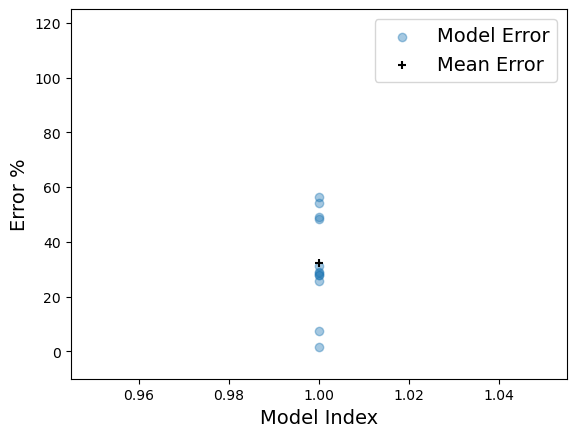

In [13]:
# plot the thing
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors[6] = colors[7]
for g, cti_path in enumerate(models):
#     print(cti_path)
    model_dir = os.path.dirname(cti_path)
    gas = ct.Solution(cti_path)

#     table_indices = [4, 7, 10]
    table_indices = [7]
    table_indices = [10]
#     print(f'P\tphi\terror')
    for table_index in table_indices:

        # slice just table 7, where phi=1.0
        table7 = df_exp[df_exp['Table'] == table_index]
        # Define Initial conditions using experimental data
        tau7 = table7['time (ms)'].values.astype(float)  # ignition delay
        T7 = table7['T_C'].values  # Temperatures
        P7 = table7['nominal pressure(atm)'].values * ct.one_atm  # pressures in atm
        phi =  df_exp[df_exp['Table'] == table_index]['phi'].values.astype(float)[0]

        errors = np.zeros(len(table7))

        # list of starting conditions
        # Mixture compositions taken from table 2 of
        # https://doi-org.ezproxy.neu.edu/10.1016/j.combustflame.2010.01.016
        concentrations = []
    #     print(phi)
        if phi == 1:
            # for phi = 1
            x_diluent = 0.7649
            conc_dict = {
                'O2(2)': 0.2038,
                'butane(1)': 0.03135
            }
        elif phi == 0.5:
            x_diluent = 0.7771
            conc_dict = {
                'O2(2)': 0.2070,
                'butane(1)': 0.01595
            }
        elif phi == 2:
            x_diluent = 0.7416
            conc_dict = {
                'O2(2)': 0.1976,
                'butane(1)': 0.06079
            }



        for i in range(0, len(table7)):
            x_N2 = table7['%N2'].values[i] / 100.0 * x_diluent
            x_Ar = table7['%Ar'].values[i] / 100.0 * x_diluent
            x_CO2 = table7['%CO2'].values[i] / 100.0 * x_diluent
            conc_dict['N2'] = x_N2
            conc_dict['Ar'] = x_Ar
            conc_dict['CO2(7)'] = x_CO2
            concentrations.append(conc_dict)


        # # Aramco naming:
        # x_diluent = 0.7649
        # conc_dict = {
        #     'O2': 0.2038,
        #     'C4H10': 0.03135
        # }

        # for i in range(0, len(table7)):
        #     x_N2 = table7['%N2'].values[i] / 100.0 * x_diluent
        #     x_Ar = table7['%Ar'].values[i] / 100.0 * x_diluent
        #     x_CO2 = table7['%CO2'].values[i] / 100.0 * x_diluent
        #     conc_dict['N2'] = x_N2
        #     conc_dict['AR'] = x_Ar
        #     conc_dict['CO2'] = x_CO2
        #     concentrations.append(conc_dict)


        # save the delays to a file
        output_file = os.path.join(model_dir, f'table_{table_index:04}', 'exp_delays.npy')
        delays = np.load(output_file)

        legend_label_model = '_nolegend_'
        legend_label_mean = '_nolegend_'
        if g == 0:
            legend_label_model = 'Model Error'
            legend_label_mean = 'Mean Error'
        

        plt.scatter([g + 1] * len(delays), get_abs_rel_error(delays, tau7 / 1000.0) * 100, alpha=0.4, color=colors[g], label=legend_label_model)
        plt.scatter(g + 1, np.mean(get_abs_rel_error(delays, tau7 / 1000.0) * 100), marker='+', color='black', label=legend_label_mean)
        
        

#         avg_error = np.average(get_abs_log10_error(delays, tau7 / 1000.0))
#         print(f'{P7[0]}\t{phi}\t{avg_error}')
    plt.ylim([-10, 125.0])
    plt.xlabel('Model Index', fontsize=14)
    plt.ylabel('Error %', fontsize=14)
    plt.legend(fontsize=14)
    

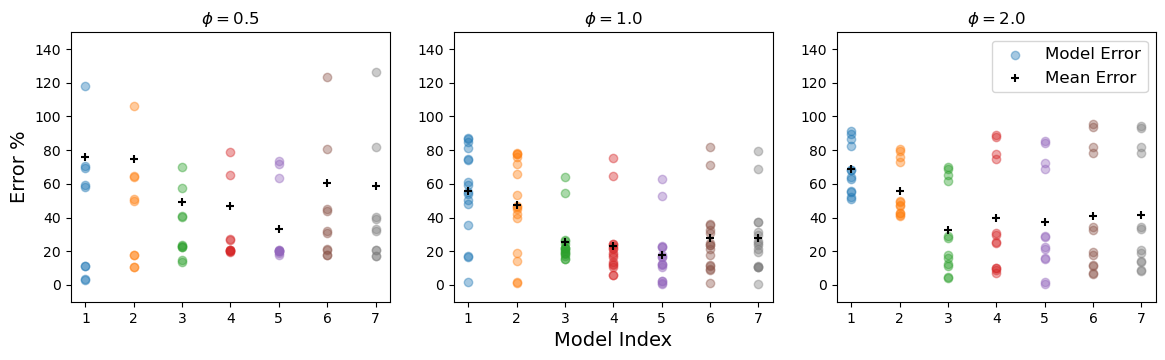

In [26]:
# plot the thing as a 1x3
models = [
    '/work/westgroup/harris.se/autoscience/fuels/butane/official/butane_20240126/chem_annotated.yaml',
    '/work/westgroup/harris.se/autoscience/fuels/butane/official/butane_20240315/chem_annotated.yaml',
    '/work/westgroup/harris.se/autoscience/fuels/butane/official/butane_20240403/chem_annotated.yaml',
    '/work/westgroup/harris.se/autoscience/fuels/butane/official/butane_20240410/chem_annotated.yaml',
    '/work/westgroup/harris.se/autoscience/fuels/butane/official/butane_20240416/chem_annotated.yaml',
    '/work/westgroup/harris.se/autoscience/fuels/butane/official/butane_20240423/chem_annotated.yaml',
    '/work/westgroup/harris.se/autoscience/fuels/butane/official/butane_20240501/chem_annotated.yaml',
]
fig, axes = plt.subplots(1, 3, figsize=(14, 3.5))
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors[6] = colors[7]
for g, cti_path in enumerate(models):
#     print(cti_path)
    model_dir = os.path.dirname(cti_path)
    gas = ct.Solution(cti_path)

    table_indices = [4, 7, 10]
#     table_indices = [7]
#     table_indices = [10]
#     print(f'P\tphi\terror')
    for n, table_index in enumerate(table_indices):

        # slice just table 7, where phi=1.0
        table7 = df_exp[df_exp['Table'] == table_index]
        # Define Initial conditions using experimental data
        tau7 = table7['time (ms)'].values.astype(float)  # ignition delay
        T7 = table7['T_C'].values  # Temperatures
        P7 = table7['nominal pressure(atm)'].values * ct.one_atm  # pressures in atm
        phi =  df_exp[df_exp['Table'] == table_index]['phi'].values.astype(float)[0]

        errors = np.zeros(len(table7))

        # list of starting conditions
        # Mixture compositions taken from table 2 of
        # https://doi-org.ezproxy.neu.edu/10.1016/j.combustflame.2010.01.016
        concentrations = []
    #     print(phi)
        if phi == 1:
            # for phi = 1
            x_diluent = 0.7649
            conc_dict = {
                'O2(2)': 0.2038,
                'butane(1)': 0.03135
            }
        elif phi == 0.5:
            x_diluent = 0.7771
            conc_dict = {
                'O2(2)': 0.2070,
                'butane(1)': 0.01595
            }
        elif phi == 2:
            x_diluent = 0.7416
            conc_dict = {
                'O2(2)': 0.1976,
                'butane(1)': 0.06079
            }



        for i in range(0, len(table7)):
            x_N2 = table7['%N2'].values[i] / 100.0 * x_diluent
            x_Ar = table7['%Ar'].values[i] / 100.0 * x_diluent
            x_CO2 = table7['%CO2'].values[i] / 100.0 * x_diluent
            conc_dict['N2'] = x_N2
            conc_dict['Ar'] = x_Ar
            conc_dict['CO2(7)'] = x_CO2
            concentrations.append(conc_dict)


        # # Aramco naming:
        # x_diluent = 0.7649
        # conc_dict = {
        #     'O2': 0.2038,
        #     'C4H10': 0.03135
        # }

        # for i in range(0, len(table7)):
        #     x_N2 = table7['%N2'].values[i] / 100.0 * x_diluent
        #     x_Ar = table7['%Ar'].values[i] / 100.0 * x_diluent
        #     x_CO2 = table7['%CO2'].values[i] / 100.0 * x_diluent
        #     conc_dict['N2'] = x_N2
        #     conc_dict['AR'] = x_Ar
        #     conc_dict['CO2'] = x_CO2
        #     concentrations.append(conc_dict)


        output_file = os.path.join(model_dir, f'table_{table_index:04}', 'exp_delays.npy')
        delays = np.load(output_file)

        legend_label_model = '_nolegend_'
        legend_label_mean = '_nolegend_'
        if g == 0:
            legend_label_model = 'Model Error'
            legend_label_mean = 'Mean Error'
        

        axes[n].scatter([g + 1] * len(delays), get_abs_log_error(delays, tau7 / 1000.0) * 100, alpha=0.4, color=colors[g], label=legend_label_model)
        axes[n].scatter(g + 1, np.mean(get_abs_log_error(delays, tau7 / 1000.0) * 100), marker='+', color='black', label=legend_label_mean)
#       
        
        
#         axes[n].scatter([g + 1] * len(delays), get_abs_rel_error(delays, tau7 / 1000.0) * 100, alpha=0.4, color=colors[g], label=legend_label_model)
#         axes[n].scatter(g + 1, np.mean(get_abs_rel_error(delays, tau7 / 1000.0) * 100), marker='+', color='black', label=legend_label_mean)

        
        axes[n].set_ylim([-10, 150])
        

#         avg_error = np.average(get_abs_log10_error(delays, tau7 / 1000.0))
#         print(f'{P7[0]}\t{phi}\t{avg_error}')
#     plt.ylim([-10, 125.0])
    axes[0].set_title(r'$\phi=0.5$')
    axes[1].set_title(r'$\phi=1.0$')
    axes[2].set_title(r'$\phi=2.0$')
    axes[1].set_xlabel('Model Index', fontsize=14)
    axes[0].set_ylabel('Error %', fontsize=14)
    plt.legend(fontsize=12)
    

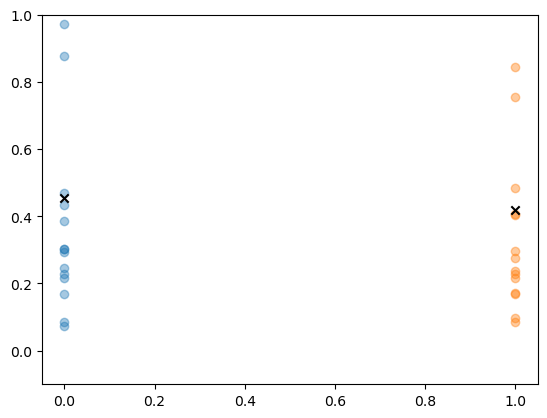

In [38]:
models = [
    '/work/westgroup/harris.se/autoscience/fuels/butane/official/with_lib/butane_20240401/chem_annotated.yaml',
    '/work/westgroup/harris.se/autoscience/fuels/butane/official/with_lib/butane_20240413/chem_annotated.yaml',
]

# plot the thing
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
for g, cti_path in enumerate(models):
#     print(cti_path)
    model_dir = os.path.dirname(cti_path)
    gas = ct.Solution(cti_path)

#     table_indices = [4, 7, 10]
    table_indices = [7]
#     print(f'P\tphi\terror')
    for table_index in table_indices:

        # slice just table 7, where phi=1.0
        table7 = df_exp[df_exp['Table'] == table_index]
        # Define Initial conditions using experimental data
        tau7 = table7['time (ms)'].values.astype(float)  # ignition delay
        T7 = table7['T_C'].values  # Temperatures
        P7 = table7['nominal pressure(atm)'].values * ct.one_atm  # pressures in atm
        phi =  df_exp[df_exp['Table'] == table_index]['phi'].values.astype(float)[0]

        errors = np.zeros(len(table7))

        # list of starting conditions
        # Mixture compositions taken from table 2 of
        # https://doi-org.ezproxy.neu.edu/10.1016/j.combustflame.2010.01.016
        concentrations = []
    #     print(phi)
        if phi == 1:
            # for phi = 1
            x_diluent = 0.7649
            conc_dict = {
                'O2(2)': 0.2038,
                'butane(1)': 0.03135
            }
        elif phi == 0.5:
            x_diluent = 0.7771
            conc_dict = {
                'O2(2)': 0.2070,
                'butane(1)': 0.01595
            }
        elif phi == 2:
            x_diluent = 0.7416
            conc_dict = {
                'O2(2)': 0.1976,
                'butane(1)': 0.06079
            }



        for i in range(0, len(table7)):
            x_N2 = table7['%N2'].values[i] / 100.0 * x_diluent
            x_Ar = table7['%Ar'].values[i] / 100.0 * x_diluent
            x_CO2 = table7['%CO2'].values[i] / 100.0 * x_diluent
            conc_dict['N2'] = x_N2
            conc_dict['Ar'] = x_Ar
            conc_dict['CO2(7)'] = x_CO2
            concentrations.append(conc_dict)


        # # Aramco naming:
        # x_diluent = 0.7649
        # conc_dict = {
        #     'O2': 0.2038,
        #     'C4H10': 0.03135
        # }

        # for i in range(0, len(table7)):
        #     x_N2 = table7['%N2'].values[i] / 100.0 * x_diluent
        #     x_Ar = table7['%Ar'].values[i] / 100.0 * x_diluent
        #     x_CO2 = table7['%CO2'].values[i] / 100.0 * x_diluent
        #     conc_dict['N2'] = x_N2
        #     conc_dict['AR'] = x_Ar
        #     conc_dict['CO2'] = x_CO2
        #     concentrations.append(conc_dict)


        # save the delays to a file
        output_file = os.path.join(model_dir, f'table_{table_index:04}', 'exp_delays.npy')
        delays = np.load(output_file)

        plt.scatter([g] * len(delays), get_abs_rel_error(delays, tau7 / 1000.0), label=g, alpha=0.4, color=colors[g])
        plt.scatter(g, np.mean(get_abs_rel_error(delays, tau7 / 1000.0)), marker='x', color='black')
        
#         avg_error = np.average(get_abs_log10_error(delays, tau7 / 1000.0))
#         print(f'{P7[0]}\t{phi}\t{avg_error}')
    plt.ylim([-0.1, 1.0])
    

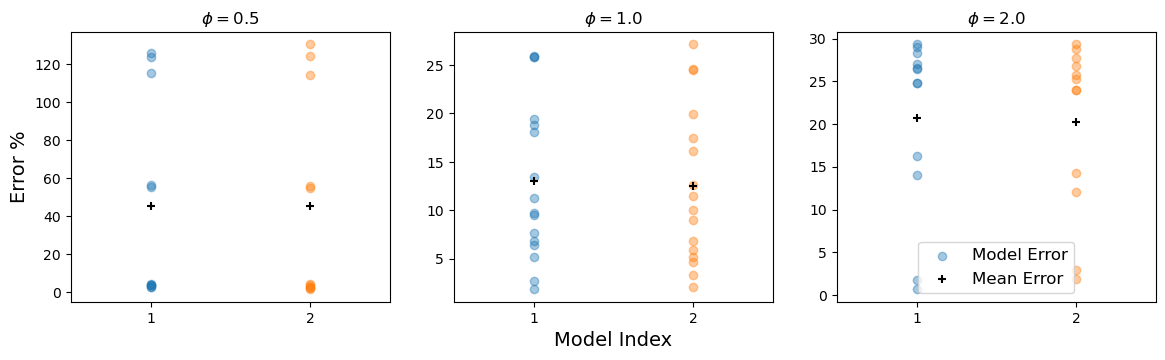

In [15]:
models = [
    '/work/westgroup/harris.se/autoscience/fuels/butane/official/with_lib/butane_20240401/chem_annotated.yaml',
    '/work/westgroup/harris.se/autoscience/fuels/butane/official/with_lib/butane_20240413/chem_annotated.yaml',
]

# plot the thing as a 1x3
fig, axes = plt.subplots(1, 3, figsize=(14, 3.5))
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors[6] = colors[7]
for g, cti_path in enumerate(models):
#     print(cti_path)
    model_dir = os.path.dirname(cti_path)
    gas = ct.Solution(cti_path)

    table_indices = [4, 7, 10]
#     table_indices = [7]
#     table_indices = [10]
#     print(f'P\tphi\terror')
    for n, table_index in enumerate(table_indices):

        # slice just table 7, where phi=1.0
        table7 = df_exp[df_exp['Table'] == table_index]
        # Define Initial conditions using experimental data
        tau7 = table7['time (ms)'].values.astype(float)  # ignition delay
        T7 = table7['T_C'].values  # Temperatures
        P7 = table7['nominal pressure(atm)'].values * ct.one_atm  # pressures in atm
        phi =  df_exp[df_exp['Table'] == table_index]['phi'].values.astype(float)[0]

        errors = np.zeros(len(table7))

        # list of starting conditions
        # Mixture compositions taken from table 2 of
        # https://doi-org.ezproxy.neu.edu/10.1016/j.combustflame.2010.01.016
        concentrations = []
    #     print(phi)
        if phi == 1:
            # for phi = 1
            x_diluent = 0.7649
            conc_dict = {
                'O2(2)': 0.2038,
                'butane(1)': 0.03135
            }
        elif phi == 0.5:
            x_diluent = 0.7771
            conc_dict = {
                'O2(2)': 0.2070,
                'butane(1)': 0.01595
            }
        elif phi == 2:
            x_diluent = 0.7416
            conc_dict = {
                'O2(2)': 0.1976,
                'butane(1)': 0.06079
            }



        for i in range(0, len(table7)):
            x_N2 = table7['%N2'].values[i] / 100.0 * x_diluent
            x_Ar = table7['%Ar'].values[i] / 100.0 * x_diluent
            x_CO2 = table7['%CO2'].values[i] / 100.0 * x_diluent
            conc_dict['N2'] = x_N2
            conc_dict['Ar'] = x_Ar
            conc_dict['CO2(7)'] = x_CO2
            concentrations.append(conc_dict)


        # # Aramco naming:
        # x_diluent = 0.7649
        # conc_dict = {
        #     'O2': 0.2038,
        #     'C4H10': 0.03135
        # }

        # for i in range(0, len(table7)):
        #     x_N2 = table7['%N2'].values[i] / 100.0 * x_diluent
        #     x_Ar = table7['%Ar'].values[i] / 100.0 * x_diluent
        #     x_CO2 = table7['%CO2'].values[i] / 100.0 * x_diluent
        #     conc_dict['N2'] = x_N2
        #     conc_dict['AR'] = x_Ar
        #     conc_dict['CO2'] = x_CO2
        #     concentrations.append(conc_dict)


        output_file = os.path.join(model_dir, f'table_{table_index:04}', 'exp_delays.npy')
        delays = np.load(output_file)

        legend_label_model = '_nolegend_'
        legend_label_mean = '_nolegend_'
        if g == 0:
            legend_label_model = 'Model Error'
            legend_label_mean = 'Mean Error'
        

        axes[n].scatter([g + 1] * len(delays), get_abs_log_error(delays, tau7 / 1000.0) * 100, alpha=0.4, color=colors[g], label=legend_label_model)
        axes[n].scatter(g + 1, np.mean(get_abs_log_error(delays, tau7 / 1000.0) * 100), marker='+', color='black', label=legend_label_mean)
        axes[n].set_xticks(range(0,4))
        axes[n].set_xlim([0.5, 2.5])
        
        
#         axes[n].scatter([g + 1] * len(delays), get_abs_rel_error(delays, tau7 / 1000.0) * 100, alpha=0.4, color=colors[g], label=legend_label_model)
#         axes[n].scatter(g + 1, np.mean(get_abs_rel_error(delays, tau7 / 1000.0) * 100), marker='+', color='black', label=legend_label_mean)

        
#         axes[n].set_ylim([-10, 150])
        

#         avg_error = np.average(get_abs_log10_error(delays, tau7 / 1000.0))
#         print(f'{P7[0]}\t{phi}\t{avg_error}')
#     plt.ylim([-10, 125.0])
    axes[0].set_title(r'$\phi=0.5$')
    axes[1].set_title(r'$\phi=1.0$')
    axes[2].set_title(r'$\phi=2.0$')
    axes[1].set_xlabel('Model Index', fontsize=14)
    axes[0].set_ylabel('Error %', fontsize=14)
    plt.legend(fontsize=12)
    

# with lib and Aramco

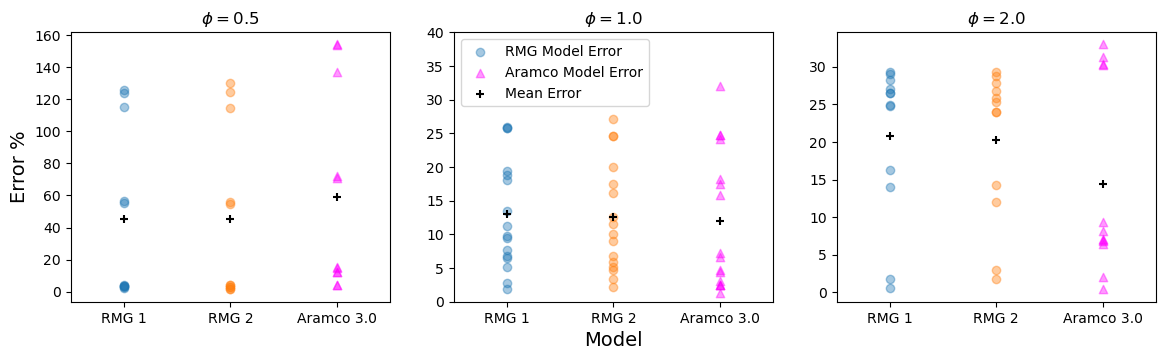

In [10]:
models = [
    '/work/westgroup/harris.se/autoscience/fuels/butane/official/with_lib/butane_20240401/chem_annotated.yaml',
    '/work/westgroup/harris.se/autoscience/fuels/butane/official/with_lib/butane_20240413/chem_annotated.yaml',
    '/work/westgroup/harris.se/autoscience/fuels/butane/official/aramco/AramcoMech3.0.MECH.cti',
]

# plot the thing as a 1x3
fig, axes = plt.subplots(1, 3, figsize=(14, 3.5))
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors[6] = colors[7]
colors[2] = 'fuchsia'
for g, cti_path in enumerate(models):
#     print(cti_path)
    model_dir = os.path.dirname(cti_path)
    gas = ct.Solution(cti_path)

    table_indices = [4, 7, 10]
#     table_indices = [7]
#     table_indices = [10]
#     print(f'P\tphi\terror')
    for n, table_index in enumerate(table_indices):

        # slice just table 7, where phi=1.0
        table7 = df_exp[df_exp['Table'] == table_index]
        # Define Initial conditions using experimental data
        tau7 = table7['time (ms)'].values.astype(float)  # ignition delay
        T7 = table7['T_C'].values  # Temperatures
        P7 = table7['nominal pressure(atm)'].values * ct.one_atm  # pressures in atm
        phi =  df_exp[df_exp['Table'] == table_index]['phi'].values.astype(float)[0]

        errors = np.zeros(len(table7))

        # list of starting conditions
        # Mixture compositions taken from table 2 of
        # https://doi-org.ezproxy.neu.edu/10.1016/j.combustflame.2010.01.016
        concentrations = []
    #     print(phi)
        if phi == 1:
            # for phi = 1
            x_diluent = 0.7649
            conc_dict = {
                'O2(2)': 0.2038,
                'butane(1)': 0.03135
            }
        elif phi == 0.5:
            x_diluent = 0.7771
            conc_dict = {
                'O2(2)': 0.2070,
                'butane(1)': 0.01595
            }
        elif phi == 2:
            x_diluent = 0.7416
            conc_dict = {
                'O2(2)': 0.1976,
                'butane(1)': 0.06079
            }



        for i in range(0, len(table7)):
            x_N2 = table7['%N2'].values[i] / 100.0 * x_diluent
            x_Ar = table7['%Ar'].values[i] / 100.0 * x_diluent
            x_CO2 = table7['%CO2'].values[i] / 100.0 * x_diluent
            conc_dict['N2'] = x_N2
            conc_dict['Ar'] = x_Ar
            conc_dict['CO2(7)'] = x_CO2
            concentrations.append(conc_dict)


        # # Aramco naming:
        # x_diluent = 0.7649
        # conc_dict = {
        #     'O2': 0.2038,
        #     'C4H10': 0.03135
        # }

        # for i in range(0, len(table7)):
        #     x_N2 = table7['%N2'].values[i] / 100.0 * x_diluent
        #     x_Ar = table7['%Ar'].values[i] / 100.0 * x_diluent
        #     x_CO2 = table7['%CO2'].values[i] / 100.0 * x_diluent
        #     conc_dict['N2'] = x_N2
        #     conc_dict['AR'] = x_Ar
        #     conc_dict['CO2'] = x_CO2
        #     concentrations.append(conc_dict)


        output_file = os.path.join(model_dir, f'table_{table_index:04}', 'exp_delays.npy')
        delays = np.load(output_file)

        legend_label_model = '_nolegend_'
        legend_label_mean = '_nolegend_'
        marker = 'o'
        alpha_value = 0.4
        if g == 0:
            legend_label_model = 'RMG Model Error'
            
        elif g == 2:
            marker = "^"
            legend_label_model = 'Aramco Model Error'
            legend_label_mean = 'Mean Error'
            alpha_value = 0.4
        

        axes[n].scatter([g + 1] * len(delays), get_abs_log_error(delays, tau7 / 1000.0) * 100, marker=marker, alpha=alpha_value, color=colors[g], label=legend_label_model)
        axes[n].scatter(g + 1, np.mean(get_abs_log_error(delays, tau7 / 1000.0) * 100), marker='+', color='black', label=legend_label_mean)
        axes[n].set_xticks(range(0,4))
        axes[n].set_xlim([0.5, 3.5])
        axes[n].set_xticklabels(['0', 'RMG 1', 'RMG 2', 'Aramco 3.0'])
        


#         avg_error = np.average(get_abs_log10_error(delays, tau7 / 1000.0))
#         print(f'{P7[0]}\t{phi}\t{avg_error}')
#     plt.ylim([-10, 125.0])
#     axes[1].set_ylim([0, 50])
    axes[0].set_title(r'$\phi=0.5$')
    axes[1].set_title(r'$\phi=1.0$')
    axes[2].set_title(r'$\phi=2.0$')
    axes[1].set_xlabel('Model', fontsize=14)
    axes[0].set_ylabel('Error %', fontsize=14)

#     axes[2].legend(bbox_to_anchor=(1.0, 1.05))
    
    axes[1].legend(loc='upper left')
    axes[1].set_ylim([0, 40])
#     axes[2].set_ylim([0, 40])
    

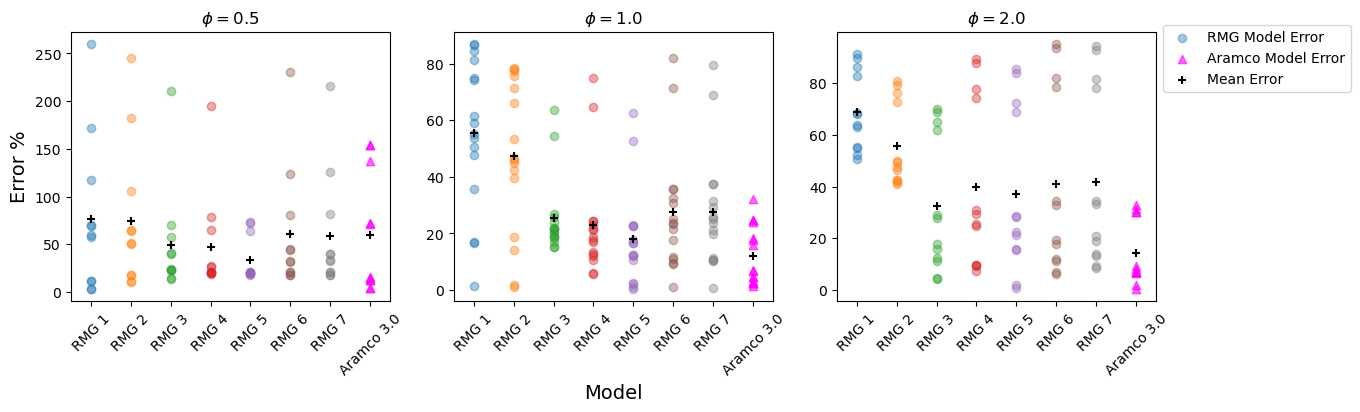

In [79]:
# plot the thing as a 1x3
models = [
    '/work/westgroup/harris.se/autoscience/fuels/butane/official/butane_20240126/chem_annotated.yaml',
    '/work/westgroup/harris.se/autoscience/fuels/butane/official/butane_20240315/chem_annotated.yaml',
    '/work/westgroup/harris.se/autoscience/fuels/butane/official/butane_20240403/chem_annotated.yaml',
    '/work/westgroup/harris.se/autoscience/fuels/butane/official/butane_20240410/chem_annotated.yaml',
    '/work/westgroup/harris.se/autoscience/fuels/butane/official/butane_20240416/chem_annotated.yaml',
    '/work/westgroup/harris.se/autoscience/fuels/butane/official/butane_20240423/chem_annotated.yaml',
    '/work/westgroup/harris.se/autoscience/fuels/butane/official/butane_20240501/chem_annotated.yaml',
    '/work/westgroup/harris.se/autoscience/fuels/butane/official/aramco/AramcoMech3.0.MECH.cti',
]
fig, axes = plt.subplots(1, 3, figsize=(14, 3.5))
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors[6] = colors[7]
colors[7] = 'fuchsia'
for g, cti_path in enumerate(models):
#     print(cti_path)
    model_dir = os.path.dirname(cti_path)
    gas = ct.Solution(cti_path)

    table_indices = [4, 7, 10]
#     table_indices = [7]
#     table_indices = [10]
#     print(f'P\tphi\terror')
    for n, table_index in enumerate(table_indices):

        # slice just table 7, where phi=1.0
        table7 = df_exp[df_exp['Table'] == table_index]
        # Define Initial conditions using experimental data
        tau7 = table7['time (ms)'].values.astype(float)  # ignition delay
        T7 = table7['T_C'].values  # Temperatures
        P7 = table7['nominal pressure(atm)'].values * ct.one_atm  # pressures in atm
        phi =  df_exp[df_exp['Table'] == table_index]['phi'].values.astype(float)[0]

        errors = np.zeros(len(table7))



        output_file = os.path.join(model_dir, f'table_{table_index:04}', 'exp_delays.npy')
        delays = np.load(output_file)

        legend_label_model = '_nolegend_'
        legend_label_mean = '_nolegend_'
        marker = 'o'
        alpha_value = 0.4
        if g == 0:
            legend_label_model = 'RMG Model Error'
            
        elif g == 7:
            marker = "^"
            legend_label_model = 'Aramco Model Error'
            legend_label_mean = 'Mean Error'
            alpha_value = 0.6
            
        axes[n].scatter([g + 1] * len(delays), get_abs_log_error(delays, tau7 / 1000.0) * 100, alpha=alpha_value, marker=marker, color=colors[g], label=legend_label_model)
        axes[n].scatter(g + 1, np.mean(get_abs_log_error(delays, tau7 / 1000.0) * 100), marker='+', color='black', label=legend_label_mean)
        
        axes[n].set_xticks(range(0, 9), rotation=45)
        axes[n].set_xlim([0.5, 8.5])
        axes[n].set_xticklabels(['0', 'RMG 1', 'RMG 2', 'RMG 3', 'RMG 4', 'RMG 5', 'RMG 6', 'RMG 7', 'Aramco 3.0'])
        
    
#         axes[n].set_ylim([-10, 150])

#         avg_error = np.average(get_abs_log10_error(delays, tau7 / 1000.0))
#         print(f'{P7[0]}\t{phi}\t{avg_error}')
#     plt.ylim([-10, 125.0])
    axes[0].set_title(r'$\phi=0.5$')
    axes[1].set_title(r'$\phi=1.0$')
    axes[2].set_title(r'$\phi=2.0$')
    axes[1].set_xlabel('Model', fontsize=14)
    axes[0].set_ylabel('Error %', fontsize=14)
#     axes[1].legend(fontsize=12)
    
    rot_angle = 45
    plt.xticks(rotation=rot_angle)
    plt.sca(axes[0])
    plt.xticks(rotation=rot_angle)
    plt.sca(axes[1])
    plt.xticks(rotation=rot_angle)
axes[2].legend(bbox_to_anchor=(1.0, 1.05))

# ylims = axes[0].get_ylim()
# axes[0].vlines(7.5, -1000, 1000, color='black', linestyle='solid')
# axes[0].set_ylim(ylims)

# ylims = axes[1].get_ylim()
# axes[1].vlines(7.5, -1000, 1000, color='black', linestyle='solid')
# axes[1].set_ylim(ylims)

# ylims = axes[2].get_ylim()
# axes[2].vlines(7.5, -1000, 1000, color='black', linestyle='solid')
# axes[2].set_ylim(ylims)